## **Introduction**
This notebook explores the performance of a simple Convolutional Neural Network through experimentation with three key parameters:

1.   Filter Size
2.   Number of Features
3.   Batch Size

The first portion of the notebook defines and trains a simple CNN to act as a baseline prior to experimentation with various parameter combinations.

In [6]:
import pathlib
import time

import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
import itertools

After all imports have completed, set a seed for PyTorch and attempt to connect to a GPU for more performant training.

In [7]:
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [8]:
# Custom Dataset class
class MNISTDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        image = self.features[idx].reshape(28, 28).astype('float32')
        label = self.targets[idx].astype('float32')
        return torch.tensor(image), torch.tensor(label)

In [9]:
# Train and Validation data
train_data_filepath = 'data/fashion-mnist_train.csv'
train_data = pl.read_csv(train_data_filepath)
train_data= train_data.drop_nulls()

feature_data = train_data.drop("label").with_columns(pl.all() / 255.0)  # Normalize pixel vals
target_data = train_data.select("label")

X = feature_data.to_numpy()
y = target_data.to_numpy().flatten()  # Flatten for PyTorch

# Split the data into training (87.5%) and validation (12.5%) sets
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=1/8,  # 12.5% validation, 87.5% training
    random_state=42,
)

# Test data
test_data_filepath = 'data/fashion-mnist_test.csv'
test_data = pl.read_csv(test_data_filepath)
test_data = test_data.drop_nulls()

X_test = test_data.drop("label").with_columns(pl.all() / 255.0).to_numpy()  # Normalize
y_test = test_data.select("label").to_numpy().flatten()

# Create Dataset objects
train_dataset = MNISTDataset(X_train, y_train)
val_dataset = MNISTDataset(X_val, y_val)
test_dataset = MNISTDataset(X_test, y_test)

In [10]:
num_epochs = 10
batch_size = 64
learning_rate = 0.001

In [11]:
# Create DataLoader objects for training, validation, and testing sets
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [12]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.relufc = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 64 * 5 * 5)
        x = self.fc1(x)
        x = self.relufc(x)
        x = self.fc2(x)
        return x

In [13]:
model = SimpleCNN().to(device)
model

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (relufc): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [14]:
# Initialize model, criterion, and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()

training_history = []
for epoch in range(num_epochs):
    model.train()
    running_training_loss = 0.0
    for images, labels in train_loader:
        images = images.unsqueeze(1).to(device)
        labels = labels.long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Check for NaN loss
        if torch.isnan(loss):
            print("NaN loss encountered!")
            break

        loss.backward()
        optimizer.step()
        running_training_loss += loss.item()

    training_loss = running_training_loss / len(train_loader)
    training_history.append({
        'epoch': epoch+1,
        'phase': 'Training',
        'loss': training_loss
    })

    # Validation step
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.unsqueeze(1).to(device)
            labels = labels.long().to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    validation_loss = running_val_loss / len(val_loader)
    training_history.append({
        'epoch': epoch+1,
        'phase': 'Validation',
        'loss': validation_loss
    })

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f' - Training for {num_epochs} took {elapsed_time:.2f} seconds.')

# Evaluate model accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.unsqueeze(1).to(device)
        labels = labels.long().to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # Compare predicted with actual labels

print(f"Accuracy of the model on the test images: {100 * correct / total:.2f}%")


Epoch [1/10], Training Loss: 1.2563, Validation Loss: 0.8595
Epoch [2/10], Training Loss: 0.7154, Validation Loss: 0.6600
Epoch [3/10], Training Loss: 0.5846, Validation Loss: 0.5969
Epoch [4/10], Training Loss: 0.5382, Validation Loss: 0.5767
Epoch [5/10], Training Loss: 0.4881, Validation Loss: 0.5260
Epoch [6/10], Training Loss: 0.4463, Validation Loss: 0.4913
Epoch [7/10], Training Loss: 0.4271, Validation Loss: 0.4588
Epoch [8/10], Training Loss: 0.4003, Validation Loss: 0.5106
Epoch [9/10], Training Loss: 0.3747, Validation Loss: 0.4634
Epoch [10/10], Training Loss: 0.3491, Validation Loss: 0.4274
 - Training for 10 took 4.52 seconds.
Accuracy of the model on the test images: 83.35%


After completing training and evaluation of the example simple CNN, training and evaluation loss for each epoch can be plotted to better understand model behavior with successive epochs

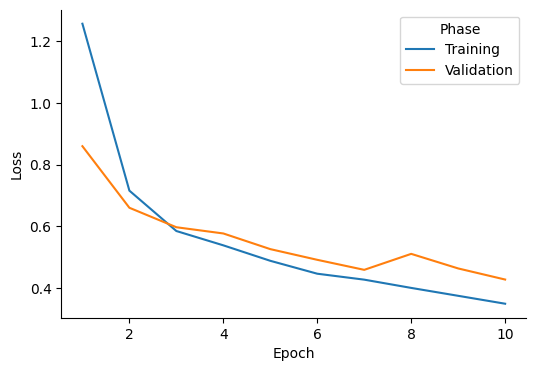

In [15]:
training_history_df = pl.DataFrame(training_history)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.lineplot(
    training_history_df,
    x='epoch',
    y='loss',
    hue='phase',
    ax=ax,
)

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(title='Phase')
ax.spines[['right', 'top']].set_visible(False)


# Parameter Experimentation
Now that a simple CNN model has been trained as a baseline, various combinations of filter size, number of features, and batch_sizes will be used to train a series of similarly structured CNN models. These will be used to illustrate the effects that each of these parameters has on the key metrics of a model. Below is a brief explanation of the three parameters used in this experiment and their expected effect on model behavior

### Filter Size
Filter size controls how much spatial context the convolutional operation "sees" as it scans the image. Smaller filters capture localized, more granular features, while larger filters capture broader spatial patterns. This means that while a small filter is better suited for finer detail, the larger filter size is more effective at capturing global features, which may be more advantageous for complex textures likely found in the dataset used here.

A smaller filter network will require more layers to capture the same information as a network with a larger filter size, however a small filter size can often achieve higher effeciency by reaching a comparable accuracy with a lower computational footprint. Larger filter sizes, alternatively, require more computational resources and are more prone to overfitting on limited datasets but often capture high level features earlier in the network

### Number of Features
The number of features per convolutional layer is representative of the hte depth of features learned by the model.A higher number of convolutional layers provides more channels for the network to capture distinct patterns. By increasing the number of features from 32 to 64 in this experiment, the number of distinct patterns the model can capture is doubled.

Raising the number of channels can increase the risk of overfitting, particularly if the dataset is limited. This is because although higher channel counts increase model flexibility, they also make the model more sensitive to noise and variation. In terms of the computational resources required, the scaling of number of features and memory usage is positively correlated. As a result, increasing the number of features often slows down training time.

### Batch Size
Batch size determines how many samples the model processes before updating weights. Smaller batches introduce more noise into the gradient calculations, so each weight update is influenced by a more variaed selection of samples. This can enhance generalization. Larger batches provide more stable gradient estimates, which can be advantageous but potentially limit the model's ability to escape local minima.

Larger batch sizes reduce the number of updates required per epoch, which can accelerate training. Conversely, smaller batch sizes, though potentially leading to better generalization, may require more epochs to converge because of the noisier gradients. This means that smaller batches are more computationally intensive. For this reason, it is often beneficial to adjust the learning rate along with batch size. Larger batch sizes generally support a higher learning rate, while smaller batches benefit from lower learning rates to prevent excessive variance in gradient updates.


In [16]:
# Define parameter combinations for the experiment
filter_sizes = [(3, 3), (5, 5)]  # Convolutional filter sizes
num_features_options = [32, 64]   # Number of output channels in convolutional layers
batch_sizes = [32, 64, 128]        # Different batch sizes


def run_experiment(filter_size, num_features, batch_size, num_epochs=10, learning_rate=0.001):
    class CustomCNN(nn.Module):
        def __init__(self, filter_size, num_features):
            super(CustomCNN, self).__init__()
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=num_features, kernel_size=filter_size)
            self.relu1 = nn.ReLU()
            self.pool1 = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(in_channels=num_features, out_channels=num_features * 2, kernel_size=filter_size)
            self.relu2 = nn.ReLU()
            self.pool2 = nn.MaxPool2d(2, 2)

            example_input = torch.zeros(1, 1, 28, 28)
            example_output = self.pool2(self.relu2(self.conv2(self.pool1(self.relu1(self.conv1(example_input))))))
            self.flattened_size = example_output.numel()

            self.fc1 = nn.Linear(self.flattened_size, 128)
            self.relufc = nn.ReLU()
            self.fc2 = nn.Linear(128, 10)

        def forward(self, x):
            x = self.conv1(x)
            x = self.relu1(x)
            x = self.pool1(x)
            x = self.conv2(x)
            x = self.relu2(x)
            x = self.pool2(x)
            x = x.view(-1, self.flattened_size)
            x = self.fc1(x)
            x = self.relufc(x)
            x = self.fc2(x)
            return x


    # Create DataLoader objects
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model
    model = CustomCNN(filter_size, num_features).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model and record time
    start_time = time.time()
    training_history = []
    for epoch in range(num_epochs):
        model.train()
        running_training_loss = 0.0
        for images, labels in train_loader:
            images = images.unsqueeze(1).to(device)
            labels = labels.to(device).long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_training_loss += loss.item()

        training_loss = running_training_loss / len(train_loader)
        training_history.append({
            'epoch': epoch + 1,
            'phase': 'Training',
            'loss': training_loss
        })

        # Validation step
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.unsqueeze(1).to(device)
                labels = labels.to(device).long()

                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

        validation_loss = running_val_loss / len(val_loader)
        training_history.append({
            'epoch': epoch + 1,
            'phase': 'Validation',
            'loss': validation_loss
        })

    end_time = time.time()
    elapsed_time = end_time - start_time

    # Evaluate accuracy on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.unsqueeze(1).to(device)
            labels = labels.to(device).long()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    return {
        'filter_size': filter_size,
        'num_features': num_features,
        'batch_size': batch_size,
        'elapsed_time': elapsed_time,
        'accuracy': accuracy
    }

# Run the factorial experiment
results = []
for filter_size, num_features, batch_size in itertools.product(filter_sizes, num_features_options, batch_sizes):
    result = run_experiment(filter_size, num_features, batch_size)
    results.append(result)
    print(f"Filter Size: {filter_size}, Num Features: {num_features}, Batch Size: {batch_size}, "
          f"Accuracy: {result['accuracy']:.2f}%, Time: {result['elapsed_time']:.2f}s")


Filter Size: (3, 3), Num Features: 32, Batch Size: 32, Accuracy: 83.72%, Time: 4.26s
Filter Size: (3, 3), Num Features: 32, Batch Size: 64, Accuracy: 83.96%, Time: 2.98s
Filter Size: (3, 3), Num Features: 32, Batch Size: 128, Accuracy: 81.92%, Time: 2.71s
Filter Size: (3, 3), Num Features: 64, Batch Size: 32, Accuracy: 85.91%, Time: 4.09s
Filter Size: (3, 3), Num Features: 64, Batch Size: 64, Accuracy: 84.49%, Time: 2.90s
Filter Size: (3, 3), Num Features: 64, Batch Size: 128, Accuracy: 80.22%, Time: 2.59s
Filter Size: (5, 5), Num Features: 32, Batch Size: 32, Accuracy: 82.90%, Time: 4.69s
Filter Size: (5, 5), Num Features: 32, Batch Size: 64, Accuracy: 83.08%, Time: 2.69s
Filter Size: (5, 5), Num Features: 32, Batch Size: 128, Accuracy: 80.86%, Time: 2.03s
Filter Size: (5, 5), Num Features: 64, Batch Size: 32, Accuracy: 84.41%, Time: 4.96s
Filter Size: (5, 5), Num Features: 64, Batch Size: 64, Accuracy: 85.01%, Time: 3.32s
Filter Size: (5, 5), Num Features: 64, Batch Size: 128, Accura

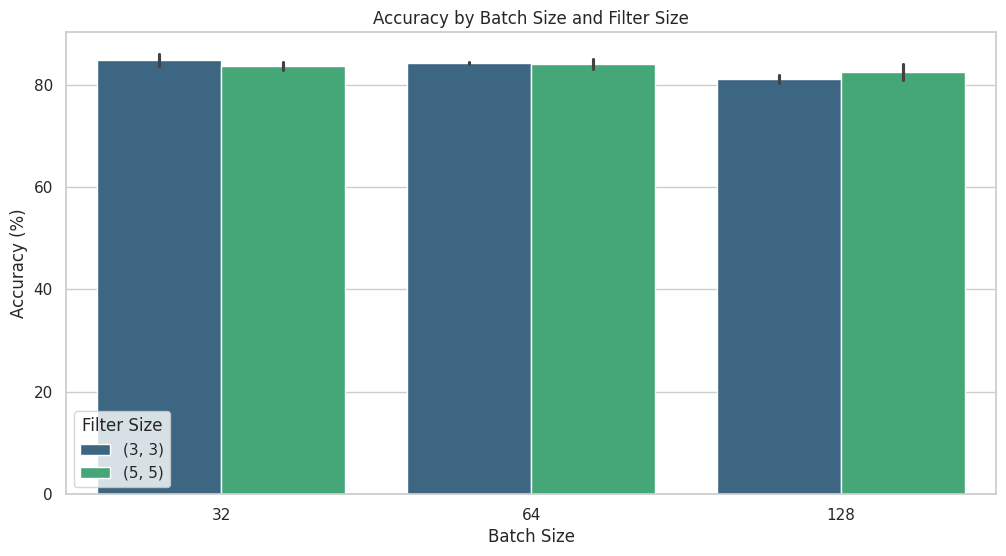

In [17]:
df = pd.DataFrame(results)
sns.set(style="whitegrid")

# Plot accuracy by batch size, with filter size and num features as additional dimensions
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='batch_size', y='accuracy', hue='filter_size', palette='viridis')
plt.title('Accuracy by Batch Size and Filter Size')
plt.ylabel('Accuracy (%)')
plt.xlabel('Batch Size')
plt.legend(title='Filter Size')
plt.show()


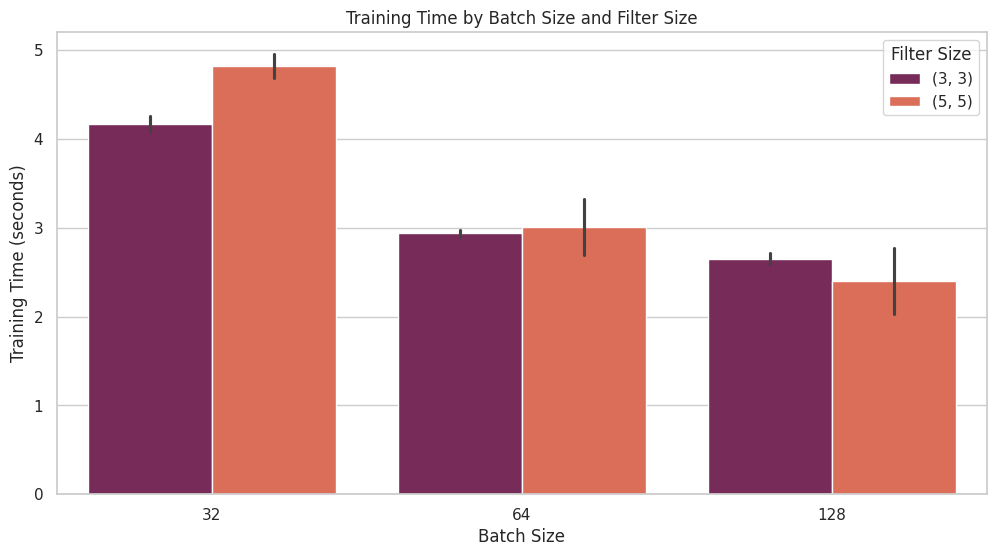

In [18]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='batch_size', y='elapsed_time', hue='filter_size', palette='rocket')
plt.title('Training Time by Batch Size and Filter Size')
plt.ylabel('Training Time (seconds)')
plt.xlabel('Batch Size')
plt.legend(title='Filter Size')
plt.show()


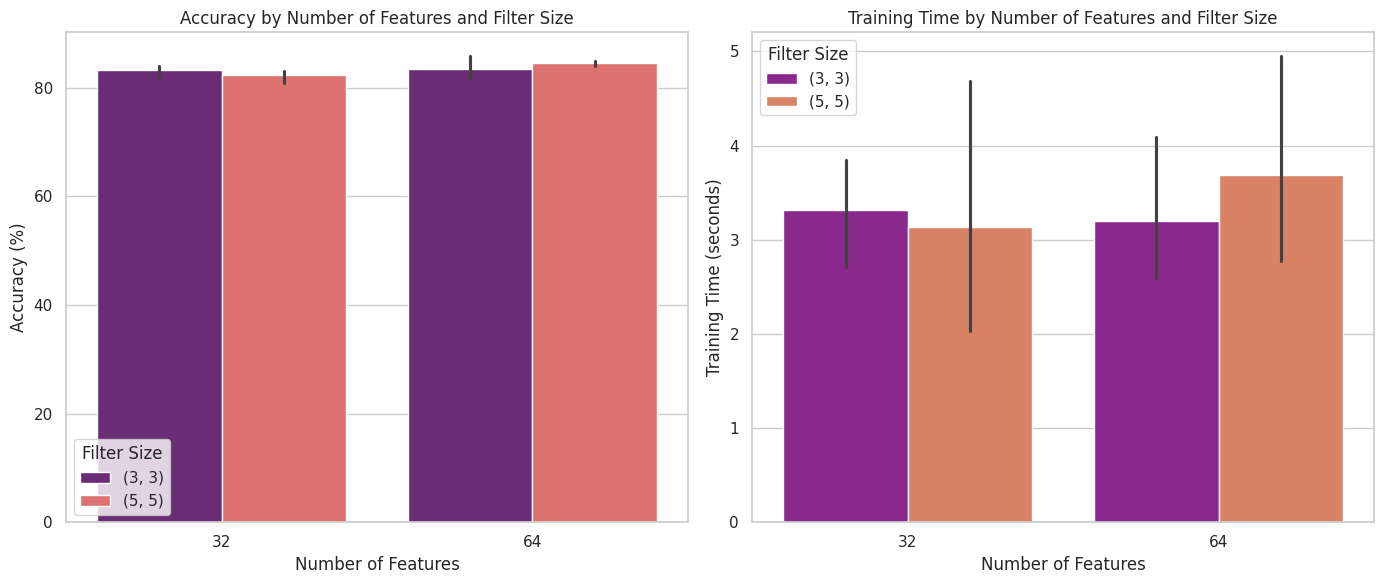

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy by number of features
sns.barplot(data=df, x='num_features', y='accuracy', hue='filter_size', ax=ax[0], palette='magma')
ax[0].set_title('Accuracy by Number of Features and Filter Size')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_xlabel('Number of Features')
ax[0].legend(title='Filter Size')

# Training time by number of features
sns.barplot(data=df, x='num_features', y='elapsed_time', hue='filter_size', ax=ax[1], palette='plasma')
ax[1].set_title('Training Time by Number of Features and Filter Size')
ax[1].set_ylabel('Training Time (seconds)')
ax[1].set_xlabel('Number of Features')
ax[1].legend(title='Filter Size')

plt.tight_layout()
plt.show()


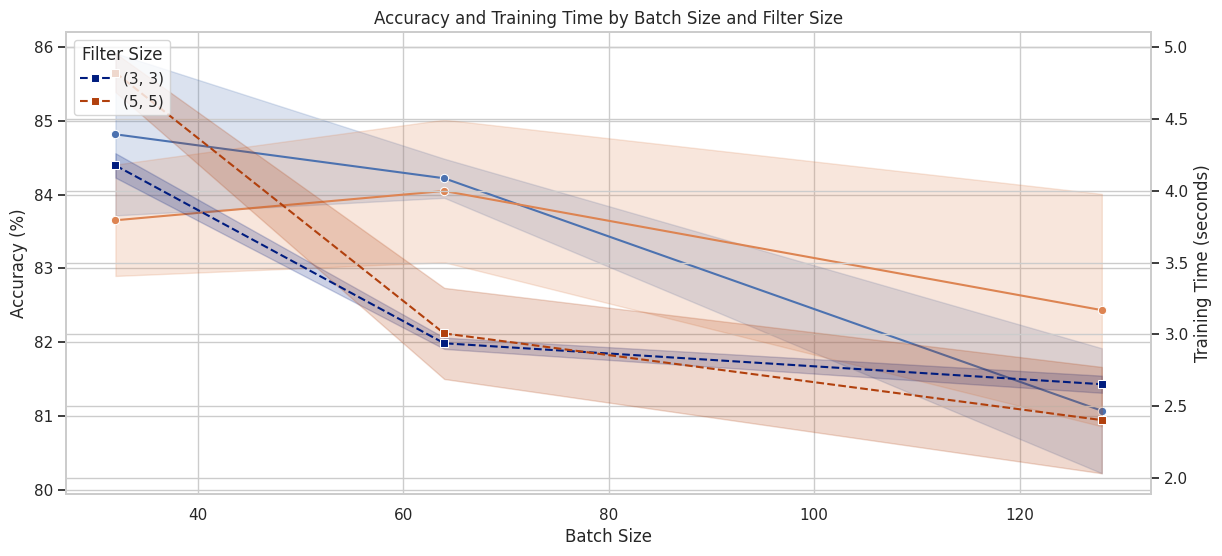

In [20]:
# Sort data
df_sorted = df.sort_values(by=['filter_size', 'num_features', 'batch_size'])
fig, ax1 = plt.subplots(figsize=(14, 6))

# Accuracy plot
sns.lineplot(data=df_sorted, x='batch_size', y='accuracy', hue='filter_size', marker='o', ax=ax1, legend=False, palette='deep')
ax1.set_ylabel('Accuracy (%)')
ax1.set_xlabel('Batch Size')
ax1.set_title('Accuracy and Training Time by Batch Size and Filter Size')

# Second y-axis for training time
ax2 = ax1.twinx()
sns.lineplot(data=df_sorted, x='batch_size', y='elapsed_time', hue='filter_size', marker='s', linestyle='--', ax=ax2, palette='dark')
ax2.set_ylabel('Training Time (seconds)')

plt.legend(title='Filter Size', loc='upper left')
plt.show()


# Results
# ---------------
### Filter Size
Increasing the filter size from (3,3) to (5,5) generally provided a slight boost in accuracy. This is likely due to the fact that larger filters capture more spatial information, ehich is useful for identifying the patterns present in the fashion MNIST data used here. If filter size were continually increased, however, one can expect accuracy to begin to decrease against the test data as the network begins to overfit to training data.

### Number of Features
Increasing the number of output channels enhances the model's ability to capture a richer set of patterns and representations, which typically leads to improved performance, especially when paired with larger filters. When paired with larger batch sizes, there seems to be a point of diminishing returns. This could indicate either that the model's capacity is sufficient with 64 features, or that further increases lead to a higher computational expense without a proportional gain in accuracy.

### Batch Size
The smaller batch sizes of 32 and 64 tend to yield a higher accuracy compared to the larger batch size of 128. This is likely due to a higher level of generalization in the network. There is a tradeoff here, however, as larger batches yield a faster training time. For these networks the difference is so minimal that this is irrelevant, but training time may be a worthwhile consideration for larger CNNs.


## Combined Effects
### Filter Size and Feature Count
The model’s complexity and representational power increase with larger filters and more features, enhancing its ability to capture detailed patterns. However, such configurations may be more prone to overfitting

### Batch Size and Learning Dynamics
Smaller batch sizes tend to work well with higher feature counts, indicating that noisier updates can help the model learn more nuanced patterns. Conversely, larger batch sizes, while effective in reducing training time, may benefit less from larger feature counts, as the updates are more stable and less exploratory.



# Takeaways
# -----------------------------------



*   For higher accuracy, it seems that a small batch size, larger filter size, and higher feature count are a good balance for this dataset
*   Larger batches reduce training time but slightly reduce accuracy. This consideration may be important for situations in which speed is a priority
* Based on the optimal parameter combination identified in this experiment, it can be observed that achieving the best accuracy often means finding a balance between model complexity and training stability.
